In [ ]:
'''
CMRMTSPL = Real Manufacturing and Trade Industries Sales
INDPRO = Industrial Production
W875RX1 = Real personal income excluding current transfer receipts
PAYEMS = Useful employment of data
'''

In [147]:
import pandas as pd
import pandas_datareader.data as web
import seaborn
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.tsa.vector_ar.var_model import VAR
import numpy as np
import datetime as dt
import sqlite3
import time
import config 
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

class Macro:
    
    """
    This class is mainly for my paper trading in spot markets. Derivatives will have a separate script. 
    """
    
    def __init__(self, condition, start, end):
        if condition == 1:
            self.period1 = start
            self.period2 = end
        else:
            self.period1 = int(time.mktime((dt.datetime.now() - dt.timedelta(365*35)).timetuple()))
            self.period2 = int(time.mktime(dt.datetime.now().timetuple()))
        
        self.fred_start = str(dt.datetime.now() - dt.timedelta(365*35)).split()[0]
        self.fred_end = dt.datetime.now()
        self.interval = '1d'
        self.symbols_list = 'CPIAUCSL','BAMLC0A4CBBBEY','BAMLC0A1CAAAEY','USALOLITONOSTSAM','DRTSCILM','DRTSCIS','IPMAN','INDPRO','M1V','M2V','MABMM301USA189S', 'WM2NS','QUSR368BIS','UMCSENT','COMREPUSQ159N','W398RC1A027NBEA','FEDFUNDS','PCETRIM12M159SFRBDAL','DGS10','DGS2','EFFR','DGS30','AAA','DBAA','BAMLH0A3HYC','BAMLH0A0HYM2','QBPBSTAS', 'TREAST', 'TREAS1T5','TREAS5T10','TREAS15', 'TCU','ICSA','AWHMAN','NEWORDER','AMTMNO','PERMIT','WEI', 'WSHOTSL', 'WSHOMCB', 'WSHOFADSL', 'WLCFLL', 'WORAL',"WALCL", "WCURCIR", 'WDTGAL', 'WLRRAL','GCEC1','PCEC96','GDPC1','FRBATLWGTUMHWG83O','PCE','UNRATE','TDSP','PALLFNFINDEXQ','TEMPHELPS','JTSHIR','PSAVERT','FYFSGDA188S','CPILFESL','PI','LNS12300060','GDPNOW','JTSJOL','CDSP','DSPI','PMSAVE','T10Y3M','PAYEMS','W875RX1','CMRMTSPL','LNS11324230'
    
    def macro(self):
        symbols = []
        for ticker in self.symbols_list: 
            try:
                r = web.DataReader(ticker,'fred', self.fred_start, self.fred_end)
                r['ticker'] = ticker
                symbols.append(r)
            except:
                msg = 'Failed to read symbol: {0!r}, replacing with NaN.'
        try:
            connection = sqlite3.connect('tradable_universe')
            for i in symbols:
                i.columns = 'close','ticker'
            final = pd.concat(symbols)
            final_df = final.reset_index()
            final_df.to_sql("macro_signals",connection, if_exists='replace', index=False)
            connection.commit()
            connection.close()
        except:
            print("There was an error in uploading the macro table into the sql database")
        return symbols, final_df
    
    
    def ticker_filter(self, ticker, final):
        return final[final['ticker']==f"{ticker}"]
    
    def dataframe(self, tickers, final, start, end):
        
        """
        Inputs: The tickers you want to filter by and a raw unfiltered data query from trading database. 
        Outputs: A dataframe with the columns being the names of the selected tickers and the values being 
        the adjusted adjusted close prices. 
        """
        
        new_df = []
        for ticker in tickers:
            new = final[final['ticker']==f"{ticker}"]
            new_df.append(new)
        main = pd.concat(new_df)
        df = main.pivot_table(index = main.index, columns = "ticker", values = 'close')
        return df[start:end]
    
class Trading:
    
    def __init__(self, condition, start, end):
        if condition == 1:
            self.period1 = start
            self.period2 = end
        else:
            self.period1 = int(time.mktime((dt.datetime.now() - dt.timedelta(365*35)).timetuple()))
            self.period2 = int(time.mktime(dt.datetime.now().timetuple()))
        
        self.fred_start = str(dt.datetime.now() - dt.timedelta(365*35)).split()[0]
        self.fred_end = dt.datetime.now()
        self.interval = '1d'
        self.ticker_list = ["SPY",'RSP',"XLV","VNQ","XLP","XLU","MUB","SPLV","DEF","XLRE","IEF",
                            "GDXJ","MBB", "UUP","IIGD","PINK","IWM","XLP","HG=F","GC=F",'XLY','^DJT','^SP500-55',
                           '^SP500-30','^SP500-25','XLK','^RUT','TLT','GLD','QQQ','GDX','GDXJ','XOP','KRE',
                           'XBI','XLF','XLE','XRT','XLI','XHB','XLP','JNK','DIA','XME','SRLN','XLC','XLB','BIL',
                           'MDY','KBE','SJNK','CWB','SDY','FEZ','XAR','GNR','KIE','XES','XSW','XSD','GXC','SPEM',
                           'SPDW','XTN','SPMB','SLYV','EFIV','EFAX','MDYV','AGG','LQD'] 
    
    def yahoo_universe(self):
        web3 = []
        failed = []
        for security in self.ticker_list:
            try:                                                    
                interval = '1d' 
                query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{security}?period1={self.period1}&period2={self.period2}&interval={self.interval}&events=history&includeAdjustedClose=true'
                df = pd.read_csv(query_string).set_index("Date")
                df['ticker'] = security
                df.columns = ['Open', 'High', 'Low','Close','Adj Close','Volume','ticker']
                web3.append(df)
            except:
                failed.append(security)                                                
                pass
            final = pd.concat(web3)
            df_final = final.reset_index()
        return df_final, web3, failed

    
    def trading_sql(self, data_file):
        try:
            conn = sqlite3.connect('tradable_universe') 
            data_file.to_sql("consensusinvestable", conn, if_exists='replace', index = False)
            conn.commit()
            conn.close()
            print("Updating the sql table was a success")
        except:
            print("Was unsuccessful in uploading the dataframe into the datatable. ")
    
    
    def to_trading_sql(self, data):
        
        """
        Inputs: dataframe you want to upload
        Outputs: saves SQL table to the investable database 
        """
        
        try:
            connection = sqlite3.connect(config.db_file)
            data.to_sql("consensusinvestable", connection, if_exists='replace', index=False)
            connection.commit()
            connection.close()
            print("Uploading dataframe to database worked successfully.")
        except:
            print("Was unable to save the dataframe into the investable datatable.")

    
    def load_sql(self):
        try:
            conn = sqlite3.connect('tradable_universe') 
            df = pd.read_sql_query("SELECT * from consensusinvestable", conn)
            conn.commit()
            conn.close()
        except:
            print("Could not retrieve the datatable. ")
        return df
    
    
    def ticker_filter(self, ticker, final):
        return final[final['ticker']==f"{ticker}"]
    
    
    def dataframe(self, tickers, final, start, end):
        
        """
        Inputs: The tickers you want to filter by and a raw unfiltered data query from trading database. 
        Outputs: A dataframe with the columns being the names of the selected tickers and the values being 
        the adjusted adjusted close prices. 
        """
        
        new_df = []
        for ticker in tickers:
            new = final[final['ticker']==f"{ticker}"]
            new_df.append(new)
        main = pd.concat(new_df)
        df = main.pivot_table(index = main.index, columns = "ticker", values = 'Adj Close')
        return df[start:end]

In [148]:
i = Macro(0, '2010-01-01','2023-05-01')

In [149]:
inst = i.macro()
data = inst[1]

In [24]:
tickers = ['DRTSCILM','DRTSCIS','GDPC1']

start = '1990-01-02'
end = dt.datetime.now()
sloos = i.dataframe(tickers, data.set_index("DATE"), start, end)
sloos['rGDP yoy'] = ((sloos['GDPC1'] / sloos['GDPC1'].shift(4)) -1)*1000
sloos['rGDP yoy lag2'] = sloos['rGDP yoy'].shift(2)

In [25]:
sloos.columns = ['Large and Medium Firms Lending Standards','Small Firms Lending Standards','GDP','Real GDP y/y','Real GDP y/y lag2']
fig = px.line(sloos['1990':].dropna().reset_index(), x="DATE", y=["Large and Medium Firms Lending Standards","Small Firms Lending Standards",'Real GDP y/y lag2'],
              hover_data={"DATE": "|%B %d, %Y"},
              title='Tight Lending Standards')
fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    xaxis_title="Date", 
    yaxis_title="SLOOS Levels"
)

In [26]:
tickers = ['PSAVERT','FRBATLWGTUMHWG83O']
start = '1990-01-02'
end = dt.datetime.now()
savings_rate = i.dataframe(tickers, data.set_index("DATE"), start, end)

In [27]:
savings_rate.columns = ['Personal Saving Rate','Median Hourly Wage Growth']
fig = px.line(savings_rate['1990':].dropna().reset_index(), x="DATE", y=["Personal Saving Rate", "Median Hourly Wage Growth"],
              hover_data={"DATE": "|%B %d, %Y"},
              title='Personal Savings Rate')
fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    xaxis_title="Date", 
    yaxis_title="Personal Savings Rate %"
)

In [29]:
tickers = ['PI']
start = '1990-01-02'
end = dt.datetime.now()
personal_income = i.dataframe(tickers, data.set_index("DATE"), start, end)

In [32]:
personal_income.columns = ['Personal Income']
fig = px.line(personal_income['1990':].dropna().reset_index(), x="DATE", y=["Personal Income"],
              hover_data={"DATE": "|%B %d, %Y"},
              title='Personal Income Back to Pre-Covid Trend')
fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    xaxis_title="Date", 
    yaxis_title="Personal Income"
)

Hires and Wages

In [36]:
tickers = ['FRBATLWGTUMHWG83O','UNRATE','TEMPHELPS','JTSHIR']
start = '1990-01-02'
end = dt.datetime.now()
unrate = i.dataframe(tickers, data.set_index("DATE"), start, end)

In [37]:
workforce = unrate[['FRBATLWGTUMHWG83O','JTSHIR']].dropna()
wf = workforce.rename(columns = {'FRBATLWGTUMHWG83O':'ATL Fed Wage Tracker',
                            'JTSHIR':'NFP: Hires'})
fig = px.line(wf.reset_index(), x="DATE", y=["NFP: Hires","ATL Fed Wage Tracker"],
              hover_data={"DATE": "|%B %d, %Y"},
              title='Hires and Wages')
fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    xaxis_title="Date", 
    yaxis_title="Hires and Wages: Levels")

Prime Age Employment to Demand 

In [150]:
tickers = ['LNS12300060','LNS11324230']
start = '1990-01-02'
end = dt.datetime.now()
age_participation = i.dataframe(tickers, data.set_index("DATE"), start, end)

In [156]:

import plotly.graph_objects as go
from plotly.subplots import make_subplots
age_participation.columns = ['Participation 25-54','Participation 55+']

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=age_participation.index, y=age_participation['Participation 25-54'], name="25-54"),
    secondary_y=False,)
fig.add_trace(
    go.Scatter(x=age_participation.index, y=age_participation['Participation 55+'], name="55+"),
    secondary_y=True,)
fig.update_layout(
    title_text="Labor Participation Rate: Shortage Led to Surge in Wages",
    width=800,
    height=800)

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="<b>55+</b> Participation Rate", secondary_y=False)
fig.update_yaxes(title_text="<b>25-54</b> Participation Rate", secondary_y=True)
fig.show()

Taking Yields at Top

In [34]:
tickers = ['EFFR','BAMLC0A4CBBBEY']
start = '1990-01-02'
end = dt.datetime.now()
ff = i.dataframe(tickers, data.set_index("DATE"), start, end)

In [35]:
ff.columns = ['Federal Funds','BBB Yields']
fig = px.line(ff['1990':].dropna().reset_index(), x="DATE", y=["Federal Funds","BBB Yields"],
              hover_data={"DATE": "|%B %d, %Y"},
              title='Fed Funds to BBB Yields')
fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    xaxis_title="Date", 
    yaxis_title="bps"
)

Personal Savings Dwindling as Wages Normalize

In [170]:
tickers = ['PMSAVE','FRBATLWGTUMHWG83O']
start = '1990-01-02'
end = dt.datetime.now()
savings_to_wages = i.dataframe(tickers, data.set_index("DATE"), start, end)

In [171]:
savings_to_wages.columns = ['ATL Fed Wages','Personal Savings']
savings_to_wages['Personal Savings divided by 100'] = savings_to_wages['Personal Savings']/100
fig = px.line(savings_to_wages['1990':].dropna().reset_index(), x="DATE", y=['ATL Fed Wages','Personal Savings divided by 100'],
              hover_data={"DATE": "|%B %d, %Y"},
              title='Normalizing Wages and Dwindling Savings')
fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    xaxis_title="Date", 
    yaxis_title=" "
)

Job Openings to Unemployment Rate - Inverse (As job openings decline, Unemployment rate ticks up)

In [172]:
tickers = ['JTSJOL','UNRATE']
start = '1990-01-02'
end = dt.datetime.now()
openings_to_unemployment = i.dataframe(tickers, data.set_index("DATE"), start, end)

In [175]:
openings_to_unemployment.columns = ['Job Openings','Unemployment Rate']

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=openings_to_unemployment.index, y=openings_to_unemployment['Job Openings'], name="Job Openings"),
    secondary_y=False,)
fig.add_trace(
    go.Scatter(x=openings_to_unemployment.index, y=openings_to_unemployment['Unemployment Rate'], name="Unemployment Rate"),
    secondary_y=True,)
fig.update_layout(
    title_text="Job Openings Realtionship with Unemployment Rate",
    width=800,
    height=800)

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="<b>Job Openings</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Unemployment Rate</b>", secondary_y=True)
fig.show()

Inverted Yield Curve 

In [176]:
tickers = ['T10Y3M']
start = '1990-01-02'
end = dt.datetime.now()
invert = i.dataframe(tickers, data.set_index("DATE"), start, end)

In [177]:
invert.columns = ['10yr Minus 3mo']
fig = px.line(invert['1990':].dropna().reset_index(), x="DATE", y=['10yr Minus 3mo'],
              hover_data={"DATE": "|%B %d, %Y"},
              title='Inverted Yield Curve since November 2022')
fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    xaxis_title="Date", 
    yaxis_title=" ")

Coincident Index is a Better Measure - CLI has been down for 21 months now 

In [198]:
tickers = ['CMRMTSPL','INDPRO','W875RX1','PAYEMS']
start = '1990-01-02'
end = dt.datetime.now()
coincident = i.dataframe(tickers, data.set_index("DATE"), start, end)
own = coincident.mean(axis=1).iloc[:-2]
own_yoy = (own / own.shift(12))-1
own_yoy = pd.DataFrame(own_yoy).dropna()
own_yoy.columns = ['Makeshift Coincident Index']


In [211]:
tickers = ['GDPC1']
start = '1990-01-02'
end = dt.datetime.now()
gdp = i.dataframe(tickers, data.set_index("DATE"), start, end)
rgdp = (gdp / gdp.shift(4)) - 1
rgdp.columns = ['Real GDP y/y']
rgdp

,Real GDP y/y
DATE,
1990-04-01,NaN
1990-07-01,NaN
1990-10-01,NaN
1991-01-01,NaN
1991-04-01,-0.005389
...,...
2022-10-01,0.006517
2023-01-01,0.017179
2023-04-01,0.023825


<Axes: xlabel='DATE'>

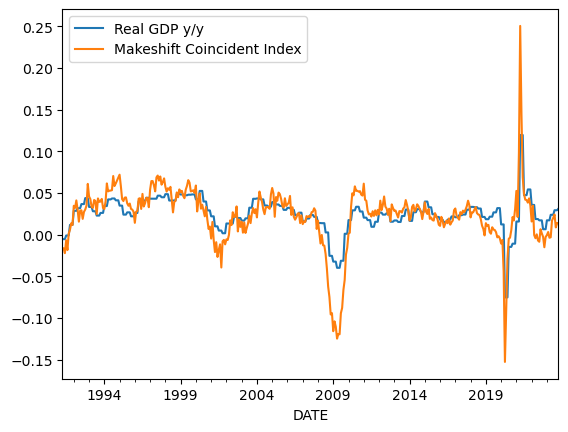

In [212]:
relationship = pd.concat([rgdp,own_yoy],axis=1).fillna(method = 'ffill').dropna()
relationship.plot()

In [213]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=relationship.index, y=relationship['Real GDP y/y'], name="Real GDP y/y"),
    secondary_y=False,)
fig.add_trace(
    go.Scatter(x=relationship.index, y=relationship['Makeshift Coincident Index'], name="Makeshift Coincident Index"),
    secondary_y=True,)
fig.update_layout(
    title_text="Real GDP y/y Realtionship with Makeshift Coincident Index",
    width=800,
    height=800)

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="<b>Real GDP y/y</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Makeshift Coincident Index</b>", secondary_y=True)
fig.show()

In [199]:
fig = px.line(own_yoy['1990':].dropna().reset_index(), x="DATE", y=['Makeshift Coincident Index'],
              hover_data={"DATE": "|%B %d, %Y"},
              title='Coincident Index')
fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    xaxis_title="Date", 
    yaxis_title=" ")

Equal Weighted Index vs SP500

In [91]:
main = Trading(0, "2018-01-01", "2020-01-01")   # set first input to one if you want exact date inputs
df, df1, df2 = main.yahoo_universe()            # dont have to run this everytime
main.trading_sql(df)   

Updating the sql table was a success


In [40]:
final = main.load_sql().set_index("Date")
tickers =["SPY","RSP","XLV","VNQ","XLP","XLU","MUB","SPLV","DEF","XLRE","IEF",
    "GDXJ","MBB", "UUP","IWM","XLP","HG=F","GC=F",'XLY','^DJT','^SP500-55',
    '^SP500-30','^SP500-25','XLK','^RUT','TLT','GLD','QQQ','GDX','GDXJ','XOP','KRE',
    'XBI','XLF','XLE','XRT','XLI','XHB','XLP','JNK','DIA','XME','SRLN','XLB',
    'MDY','KBE','SJNK','CWB','SDY','FEZ','XAR','GNR','KIE','XES','XSW','XSD','GXC','SPEM',
    'SPDW','XTN','SPMB','SLYV','MDYV']
start = '2000-01-01'
end = '2024-01-12'
dfcap = main.dataframe(tickers, final, start, end)
dfcap = dfcap.dropna()
dfcap['DiscretionaryToStaples'] = dfcap["^SP500-25"] / dfcap["^SP500-30"]
dfcap['TransportsToUtilities'] = (dfcap["^DJT"] / dfcap["^SP500-55"])/100
dfcap['CopperToGold'] = (dfcap["HG=F"] / dfcap["GC=F"])*100
dfcap.index = pd.to_datetime(dfcap.index)
daily = dfcap.copy()
daily

ticker,CWB,DEF,DIA,FEZ,GC=F,GDX,GDXJ,GLD,GNR,GXC,...,XSW,XTN,^DJT,^RUT,^SP500-25,^SP500-30,^SP500-55,DiscretionaryToStaples,TransportsToUtilities,CopperToGold
Date,,,,,,,,,,,,,,,,,,,,,
2015-10-08,33.255119,34.654308,143.067352,28.385975,1144.699951,14.120077,18.683385,109.139999,27.728558,62.732281,...,48.068184,42.822712,8191.629883,1163.239990,615.750000,506.739990,223.399994,1.215120,0.366680,0.205032
2015-10-09,33.284061,34.580933,143.394836,28.544107,1156.300049,14.898928,19.601072,110.870003,27.992285,62.590435,...,48.358978,43.782131,8253.160156,1165.359985,616.789978,508.100006,222.490005,1.213915,0.370945,0.209029
2015-10-12,33.262344,34.626137,143.739166,28.472946,1164.900024,14.459106,19.405062,111.309998,27.668276,62.932541,...,48.320198,43.892818,8260.929688,1164.400024,619.710022,509.290009,224.500000,1.216812,0.367970,0.207700
2015-10-13,33.081383,34.344025,143.294083,28.188303,1165.800049,14.541573,19.244690,111.860001,27.208647,62.239964,...,47.893688,42.721252,8077.740234,1147.839966,616.309998,506.000000,223.919998,1.218004,0.360742,0.205138
2015-10-14,33.197205,34.322548,141.975647,28.306902,1180.099976,15.485355,20.688039,113.809998,27.547716,62.206600,...,47.409039,42.813492,8091.950195,1136.969971,610.030029,500.269989,223.910004,1.219402,0.361393,0.205067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-08,71.190002,71.843201,376.625854,47.209999,2026.599976,29.700001,35.889999,187.869995,55.959999,64.930000,...,145.839996,82.139999,15645.959961,1989.010010,1393.359985,767.989990,330.209991,1.814294,0.473818,0.187481
2024-01-09,71.129997,71.708199,374.966797,46.689999,2026.400024,29.170000,35.360001,187.929993,54.959999,64.220001,...,145.250000,81.040001,15512.299805,1968.040039,1391.469971,769.840027,327.709991,1.807479,0.473354,0.184983
2024-01-10,71.370003,71.984497,376.735809,46.950001,2021.699951,29.110001,35.480000,187.500000,54.590000,64.070000,...,147.139999,81.099998,15602.870117,1970.260010,1405.160034,768.869995,327.500000,1.827565,0.476424,0.187021


In [47]:
final = main.load_sql().set_index("Date")
tickers =["SPY"]
start = '2000-01-01'
end = '2024-01-12'
dfcap = main.dataframe(tickers, final, start, end)
dfcap = dfcap.dropna()
dfcap.index = pd.to_datetime(dfcap.index)
daily = dfcap.copy()
daily

ticker,SPY
Date,
2000-01-03,93.881958
2000-01-04,90.210571
2000-01-05,90.371948
2000-01-06,88.919518
2000-01-07,94.083618
...,...
2024-01-08,474.600006
2024-01-09,473.880005
2024-01-10,476.559998


<Axes: xlabel='Date'>

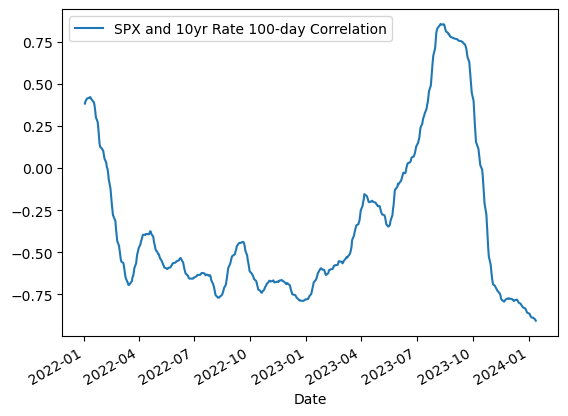

In [89]:
tickers = ['DGS10']
start = '1990-01-02'
end = dt.datetime.now()
rates = i.dataframe(tickers, data.set_index("DATE"), start, end)
r_e = pd.concat([rates, daily],axis=1).dropna()
corr = r_e.rolling(window=100).corr()['DGS10'].dropna()
corr_df = pd.DataFrame(corr).reset_index()
corr_df1 = corr_df[corr_df['ticker']=='SPY'].set_index('level_0')[['DGS10']]
corr_df1.columns = ['SPX and 10yr Rate 100-day Correlation']
corr_df1.index.names = ['Date']
corr_df1['2022':].plot()

In [92]:
final = main.load_sql().set_index("Date")
tickers =["SPY","LQD"]
start = '2000-01-01'
end = '2024-01-12'
dfcap = main.dataframe(tickers, final, start, end)
dfcap = dfcap.dropna()
dfcap.index = pd.to_datetime(dfcap.index)
daily = dfcap.copy()
daily

ticker,LQD,SPY
Date,,
2002-07-30,41.007069,60.462009
2002-07-31,41.257854,60.608280
2002-08-01,41.662395,59.025909
2002-08-02,41.747314,57.702869
2002-08-05,41.646221,55.695004
...,...,...
2024-01-08,109.489998,474.600006
2024-01-09,109.680000,473.880005
2024-01-10,109.540001,476.559998


<Axes: xlabel='Date'>

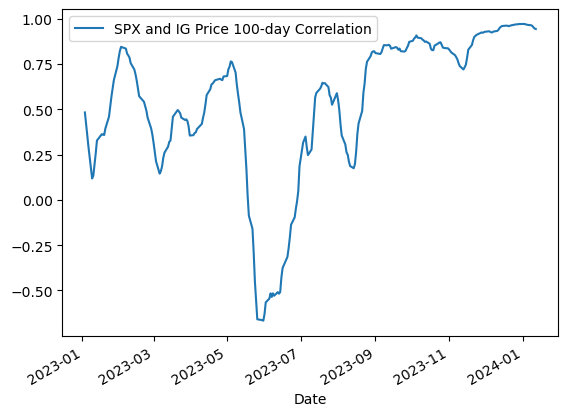

In [111]:
corr = daily.rolling(window=40).corr().dropna()[['LQD']]
corr_df = pd.DataFrame(corr).reset_index()
corr_df1 = corr_df[corr_df['ticker']=='SPY'].set_index('Date')[['LQD']]
corr_df1.columns = ['SPX and IG Price 100-day Correlation']
corr_df1.index.names = ['Date']
corr_df1['2023':].plot()

In [115]:
final = main.load_sql().set_index("Date")
tickers =["LQD","AGG","SPY"]
start = '2000-01-01'
end = '2024-01-12'
dfcap = main.dataframe(tickers, final, start, end)
dfcap = dfcap.dropna()
dfcap.index = pd.to_datetime(dfcap.index)
daily = dfcap.copy()
daily

ticker,AGG,LQD,SPY
Date,,,
2003-09-29,54.216274,48.454777,68.516785
2003-09-30,54.497501,48.776222,67.851509
2003-10-01,54.470978,48.916588,69.297462
2003-10-02,54.386059,48.728577,69.548653
2003-10-03,53.993374,48.050873,70.186783
...,...,...,...
2024-01-08,98.570000,109.489998,474.600006
2024-01-09,98.550003,109.680000,473.880005
2024-01-10,98.360001,109.540001,476.559998


Fixed Income Outperforming during a Fed Pause

In [129]:
hc = daily[['AGG','LQD','SPY']]['2007-07-20':'2007-10-01'].pct_change().dropna()
hc_norm = (1 + hc).cumprod() - 1
fig = px.line(hc_norm.dropna().reset_index(), x="Date", y=['AGG','LQD','SPY'],
              hover_data={"Date": "|%B %d, %Y"},
              title='SPY v Fixed Income: Pause August 2007')

fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=1200,
    height=800,
    xaxis_title="Date", 
    yaxis_title="Cumulative Gains (Based on Price)"
)

Consumer Staples over Consumer Discretionary

In [138]:
final = main.load_sql().set_index("Date")
tickers =["XLY","XLP","SPY","XLV"]
start = '2000-01-01'
end = '2024-01-12'
dfcap = main.dataframe(tickers, final, start, end)
dfcap = dfcap.dropna()
dfcap.index = pd.to_datetime(dfcap.index)
daily = dfcap.copy()
daily

ticker,SPY,XLP,XLV,XLY
Date,,,,
2000-01-03,93.881927,12.893021,21.217457,22.727604
2000-01-04,90.210556,12.529968,20.735992,22.043888
2000-01-05,90.371933,12.751341,20.549967,21.772764
2000-01-06,88.919548,12.990432,20.615623,22.020315
2000-01-07,94.083626,13.813954,20.867289,23.057674
...,...,...,...,...
2024-01-08,474.600006,72.540001,140.350006,175.559998
2024-01-09,473.880005,72.730003,140.330002,174.910004
2024-01-10,476.559998,72.580002,140.970001,176.309998


In [139]:
hc = daily[['XLY','XLP','SPY']]['2019-09':'2020-01-01'].pct_change().dropna()
hc_norm = (1 + hc).cumprod() - 1
fig = px.line(hc_norm.dropna().reset_index(), x="Date", y=['XLY','XLP','SPY'],
              hover_data={"Date": "|%B %d, %Y"},
              title='Consumer Staples Outperforming in Contracting Growth - Real GDP YoY')

fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=1200,
    height=800,
    xaxis_title="Date", 
    yaxis_title="Cumulative Gains (Based on Price)")

In [142]:
hc = daily[['XLV','SPY']]['2019-10':'2020-01-01'].pct_change().dropna()
hc_norm = (1 + hc).cumprod() - 1
fig = px.line(hc_norm.dropna().reset_index(), x="Date", y=['XLV','SPY'],
              hover_data={"Date": "|%B %d, %Y"},
              title='Healthcare: Declining Growth')

fig.update_xaxes(
    dtick="M1",
    tickmode= 'auto',
    tickformat= '%b\n%Y')

fig.update_layout(
    autosize=False,
    width=1200,
    height=800,
    xaxis_title="Date", 
    yaxis_title="Healthcare Outperforming in Contracting Growth - Real GDP YoY")

Personal Savings Rundown as well as Wage Normalization

Healthcare and Utilities 

ERP of the Dow Jones